# OPTRAM

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

## LOAD DATA

In [27]:
names = ["site", "year", "day", "hr", "mn", "SM5", "SM15", "SM30", "SM50", "SM75", "SM100", "SM200"]
l1tdr17 = pd.read_csv('https://www.tucson.ars.ag.gov/metDAP/SoilProfileSiteData/l1tdr17.out',
                  sep='\s+', 
                  names = names)

In [30]:
l1tdr17["datetime"] = (
                        pd.to_datetime(l1tdr17['year'] * 1000 + l1tdr17['day'], format='%Y%j') 
                        +
                        pd.to_timedelta(l1tdr17["hr"], unit="h") 
                        +
                        pd.to_timedelta(l1tdr17["mn"], unit="min") 
                      )

In [ ]:
l1tdr17.set_index('datetime', inplace = True)

In [33]:
l1tdr17

,site,year,day,hr,mn,SM5,SM15,SM30,SM50,SM75,SM100,SM200
datetime,,,,,,,,,,,,
2017-01-01 00:30:00,3008,2017,1,0,30,11,8,6,6,15,12,14
2017-01-01 01:00:00,3008,2017,1,1,0,11,9,6,6,14,12,14
2017-01-01 01:30:00,3008,2017,1,1,30,11,8,6,6999,15,13,14
2017-01-01 02:00:00,3008,2017,1,2,0,11,8,6,6,15,12,14
2017-01-01 02:30:00,3008,2017,1,2,30,12,7,6,6,14,12,13
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 22:00:00,3008,2017,365,22,0,5,6,6,5,11,12,14
2017-12-31 22:30:00,3008,2017,365,22,30,5,6,7,6,11,12,14
2017-12-31 23:00:00,3008,2017,365,23,0,5,6,5,6,12,12,14


<AxesSubplot:xlabel='datetime'>

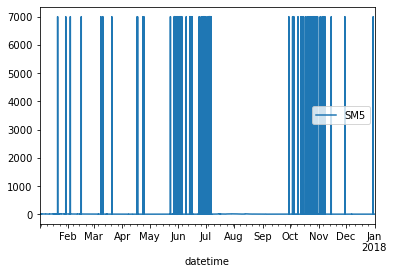

In [39]:
l1tdr17.plot(y='SM5', use_index=True)

In [43]:
l1tdr17_fix = l1tdr17.replace(6999, None)

<AxesSubplot:xlabel='datetime'>

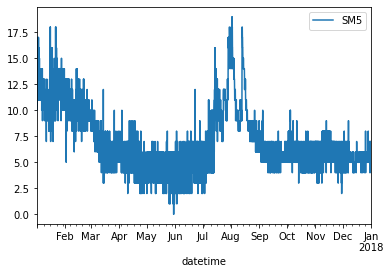

In [44]:
l1tdr17_fix.plot(y='SM5', use_index=True)